<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Ruslan-Kuzminov-folder/Ruslan-Kuzminov/identification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Идентификация по сетчатке глаза

## **Финальная работа**

**Задача:** идентификация пациента по радужной оболочке глаза (Iris ID)

**Тип задачи:** классификация.

**Количество классов:** равно удвоенному количеству пациентов (левый и
правый глаз).

**Датасет:** цветные изображения переднего сегмента глаз в формате png.

**Требуемая точность:** FRR (ложный недопуск) ошибка не более 3%, FAR (ложный
допуск) ошибка не более 3%, идентификация: точность не менее 97%.

**Тестируемая гипотеза:** обучение на извлеченных из изображения радужной оболочки признаках с помощью вейвлетов Габора

**План работ:**

1. проверяем содержимое датасета
2. проводим предобработку изображений
3. разворачиваем радужку (переход от полярных координат в декартовы), применяем фильтр Гаусса и оператор Лапласа,извлекаем признаки с помощью вейвлетов Габора
4. готовим датасет к обучению
5. формируем архитектуру нейросети и проводим обучение модели
6. исследуем результат

### Подключение библиотек

In [ ]:
# импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

import os
import gdown
import cv2

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, SpatialDropout2D, BatchNormalization, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import VGG16
import tensorflow as tf

import random
import math

from tqdm.notebook import tqdm as tq

from scipy.ndimage import gaussian_laplace
from skimage.filters import gabor
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

from google.colab import drive

### Загрузка данных

In [ ]:
# подключаем google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# проверяем содержимое папки

IMAGE_TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/educations/internships/images_train'
IMAGE_VALID_PATH = '/content/drive/MyDrive/Colab Notebooks/educations/internships/images_valid'
IMAGE_TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/educations/internships/images_test'

IMAGE_FILES_TRAIN = sorted(os.listdir(IMAGE_TRAIN_PATH))
IMAGE_FILES_VALID = sorted(os.listdir(IMAGE_VALID_PATH))
IMAGE_FILES_TEST = sorted(os.listdir(IMAGE_TEST_PATH))

print(IMAGE_FILES_TRAIN[:5])
print(IMAGE_FILES_VALID[:5])
print(IMAGE_FILES_TEST[:5])

['001L_1.png', '001R_1.png', '002L_1.png', '002R_1.png', '003L_1.png']
['001L_2.png', '001R_2.png', '002L_2.png', '002R_2.png', '003L_2.png']
['001L_3.png', '001R_3.png', '002L_3.png', '002R_3.png', '003L_3.png']


### Проверка содержимого датасета

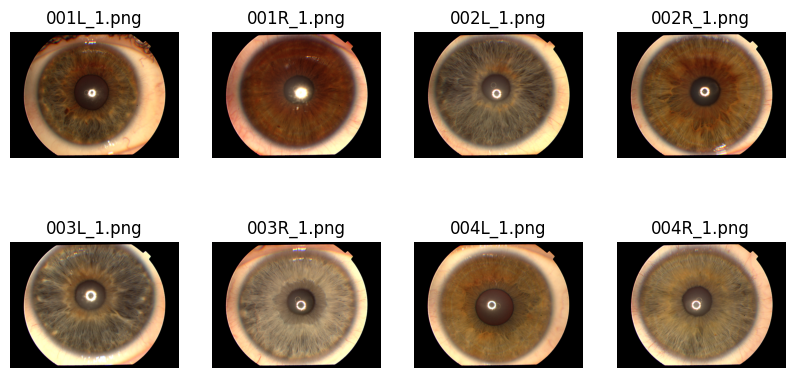

In [ ]:
# выводим серию случайных изображений на экран

fig = plt.figure(figsize=(10,5))

for i in range(len(IMAGE_FILES_TRAIN)):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_path = dirs_path + random.choice(os.listdir(dirs_path))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(IMAGE_FILES_TRAIN[i])
    ax.imshow(Image.open(img_path))
    ax.axis('off')
    if i == 7: # остановить добавление изображений после 8
        break

plt.show()

**Наблюдения:**
- у каждого изображения имеется уголок в правой верхней части изображения
- на зрачках присутствует отражение лампы
- не все зрачки расположены четко по центру
- на некоторых радужках присутствуют блики лампы
- на некоторых изображениях в кадр попадает веко и ресницы

**Выводы:**
- данные артефакты могут создавать шум и/или являться ложными признаками в процессе обучения нейронной сети. В рамках данной работы постараемся их обрезать и/или свести к минимуму их влияние

### Предобработка изображений

In [ ]:
# создаем функцию обрезки изображения

def crop_circular_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Конвертация из BGR в RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Получение размеров изображения
    height, width, _ = image.shape

    # Создание круглой маски
    mask = np.zeros((height, width), np.uint8)
    center = (width // 2, height // 2)
    radius = int(min(width, height) // 2.25)
    cv2.circle(mask, center, radius, (255, 255, 255), -1)

    # Применение маски к изображению
    circular_image = cv2.bitwise_and(image, image, mask=mask)

    # Вычисление координат верхнего левого угла прямоугольника
    x = int((width - min(width, height)) // 2.1)
    y = int((height - min(width, height)) // 2)

    # Вырезание прямоугольной области из изображения
    cropped_image = circular_image[y:y + min(width, height), x:x + min(width, height)]

    # Получение размеров обрезанного изображения
    cropped_height, cropped_width, _ = cropped_image.shape

    # Переопределение центра и радиуса для обрезанного изображения
    center = (cropped_width // 2, cropped_height // 2)
    radius = min(cropped_width, cropped_height) // 2

    # Создание черной круглой маски для закрытия зрачка
    cropped_image = cv2.circle(cropped_image, center, int(radius * 0.3), (0, 0, 0), -1)

    return cropped_image, center, radius

In [ ]:
# создаем функцию полярного преобразования координат

def unwrap_image(cropped_image, center, radius):
    # создаем новое изображения для результатов развертывания
    unwrapped_image = np.zeros((radius, 360, 3), dtype=np.uint8)

    # пройдем по всем пикселям в новом изображении и копируйте их из обрезанного изображения
    for r in range(radius):
        for theta in range(360):
            # преобразуем полярные координаты в декартовы
            x_unwrap = center[0] + r * np.cos(np.deg2rad(theta))
            y_unwrap = center[1] + r * np.sin(np.deg2rad(theta))

            # копируем пиксель
            unwrapped_image[r, theta] = cropped_image[int(y_unwrap), int(x_unwrap)]

    # обрезание изображения для получения прямоугольника в центре
    rectangle_height = int(radius // 2.5) #  сохраняем центральную треть изображения
    rectangle_start = int((radius - rectangle_height) // 2) # начало прямоугольника
    rectangle_image = unwrapped_image[rectangle_start : rectangle_start + rectangle_height, :]

    return rectangle_image

In [ ]:
# создаем фильтр Гаусса и оператор Лапласа
def apply_gaussian_laplace(image, sigma=1.2):
    # Применение фильтра Гаусса и оператора Лапласа
    filtered_image = gaussian_laplace(image, sigma)

    return filtered_image

# создаем функцию для извлечения признаков с использованием вейвлетов Габора
def apply_gabor_filter(image, frequency=0.7):
    # преобразование изображения в оттенки серого, если оно цветное
    if len(image.shape) > 2:
        image = rgb2gray(image)

    # применение фильтра Габора
    gabor_response, _ = gabor(image, frequency)

    # нормализация gabor_response в диапазон [0, 1]
    gabor_response = (gabor_response - gabor_response.min()) / (gabor_response.max() - gabor_response.min())

    # преобразование gabor_response в тип uint8
    gabor_response = (gabor_response * 255).astype(np.uint8)

    # адаптивная бинаризация изображения
    binary_gabor = cv2.adaptiveThreshold(gabor_response, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    return binary_gabor

In [ ]:
# cоздаем функцию, применяющую все фильтры к изображению

def process_images(directory_path):
    result = []

    for img_file in tq(sorted(os.listdir(directory_path))):
        img_path = os.path.join(directory_path, img_file)

        # применяем функцию обрезки изображения
        cropped_image, center, radius = crop_circular_image(img_path)

        # "Разворачивание" обрезанного изображения
        unwrapped_image = unwrap_image(cropped_image, center, radius)

        # Применение фильтра Гаусса и оператора Лапласа
        gauss_laplace_img = apply_gaussian_laplace(unwrapped_image)

        # Извлечение признаков с использованием вейвлетов Габора
        gabor_img = apply_gabor_filter(gauss_laplace_img)

        # Получаем метку (label) из имени файла
        label = os.path.splitext(img_file)[0][:-2]

        # Сохранение результата
        result.append({
            "file_name": img_file,
            "gabor_filter": gabor_img,
            "label": label
        })

    return result

In [ ]:
def print_dictionary_structure(processed_images):
    # Печатаем количество элементов в списке
    print(f'Количество изображений: {len(processed_images)}')
    # Собираем все метки в список
    labels = [image['label'] for image in processed_images]
    # Выводим количество уникальных меток
    print(f'Количество меток: {len(labels)}')

    if processed_images:
        # Получаем первый элемент
        first_image = processed_images[0]

        # Печатаем все ключи и их типы данных
        for key, value in first_image.items():
            print(f'{key}: {type(value)}')

        # Если значение - массив numpy, выводим его форму
        if isinstance(first_image['gabor_filter'], np.ndarray):
            print('Размер изображений:', first_image['gabor_filter'].shape)
    else:
        print("List 'processed_images' is empty.")

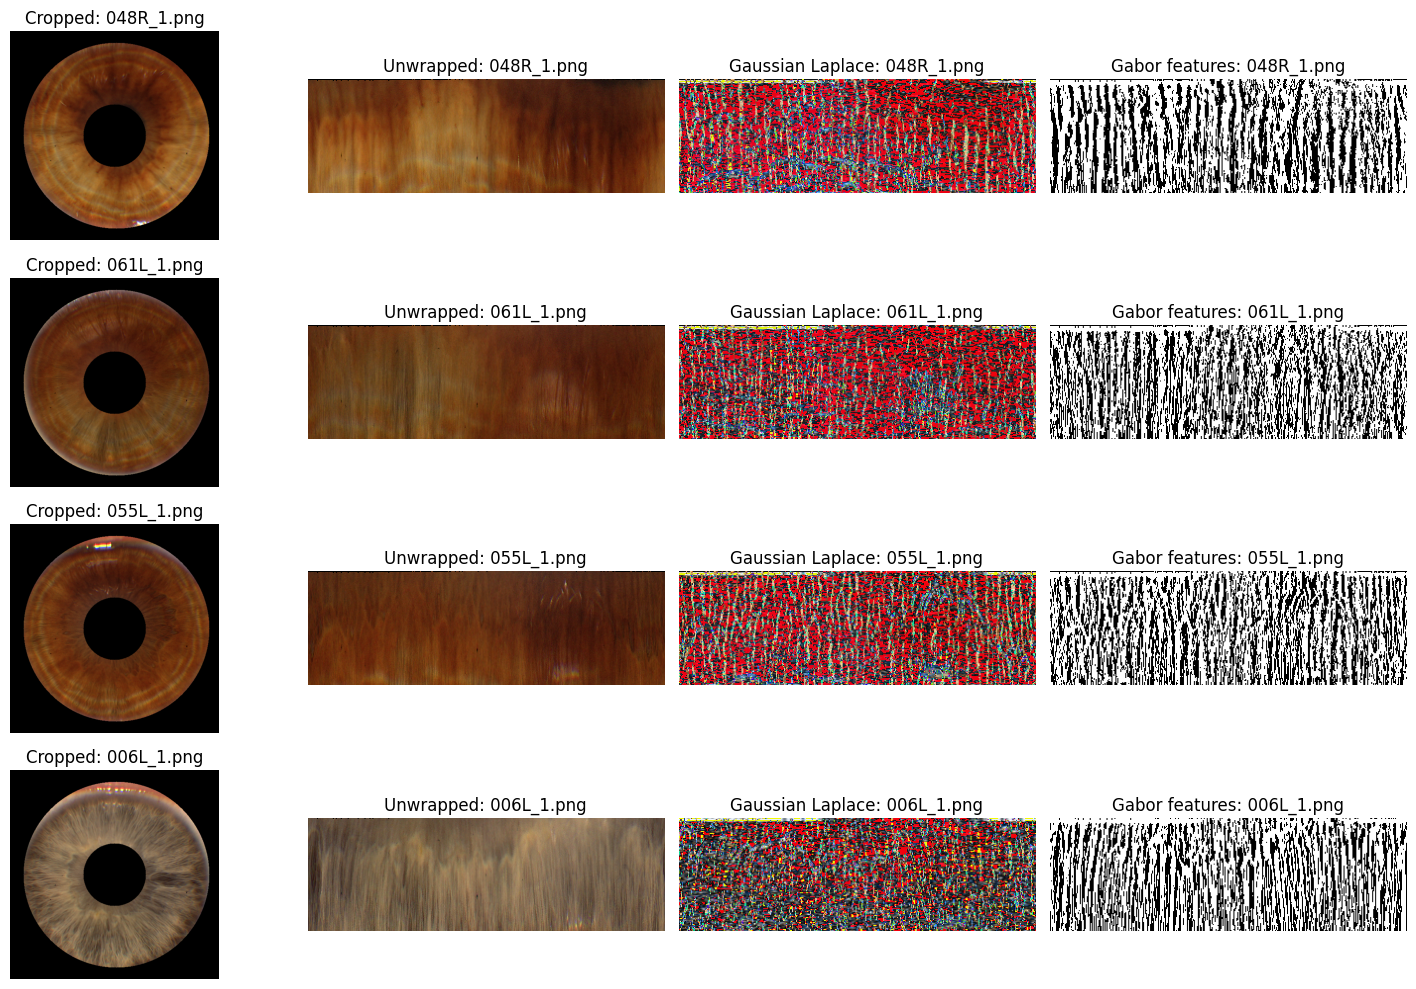

In [ ]:
# выводим результаты применения фильтров

fig, axs = plt.subplots(4, 4, figsize=(15, 10)) # создаем 8 строк по 4 столбца

for i in range(4):
    dirs_path = f'{IMAGE_TRAIN_PATH}/'
    img_file = random.choice(os.listdir(dirs_path))
    img_path = dirs_path + img_file

    # Получение обрезанного изображения, центра и радиуса
    cropped_image, center, radius = crop_circular_image(img_path)

    # "Разворачивание" обрезанного изображения
    unwrapped_image = unwrap_image(cropped_image, center, radius)

    # Применение фильтра Гаусса и оператора Лапласа
    gaussian_laplace_image = apply_gaussian_laplace(unwrapped_image)

    # Извлечение признаков с использованием вейвлетов Габора
    gabor_features = apply_gabor_filter(unwrapped_image)

    # выводим обрезанное изображение
    axs[i, 0].imshow(cropped_image)
    axs[i, 0].set_title('Cropped: ' + img_file)
    axs[i, 0].axis('off')

    # выводим развернутое изображение
    axs[i, 1].imshow(unwrapped_image)
    axs[i, 1].set_title('Unwrapped: ' + img_file)
    axs[i, 1].axis('off')

    # выводим изображение после применения фильтра Гаусса и оператора Лапласа
    axs[i, 2].imshow(gaussian_laplace_image, cmap='gray')
    axs[i, 2].set_title('Gaussian Laplace: ' + img_file)
    axs[i, 2].axis('off')

    # выводим изображение после извлечения признаков с использованием вейвлетов Габора
    axs[i, 3].imshow(gabor_features, cmap='gray')
    axs[i, 3].set_title('Gabor features: ' + img_file)
    axs[i, 3].axis('off')

plt.tight_layout() # делаем более компактное расположение графиков
plt.show()

**Результаты:**
- были обрезаны: выступающий край, веко, ресницы (там, где это возможно, с минимизацией ущерба для считываемой области)
- зрачок был центрирован и обрезан по краям (для снижения размера изображения)
- центр зрачка закрашен черной маской (для снятия блика лампы)
- изображение радужки было развернуто, к ней были применены фильтр Гаусса, оператор Лапласа.
- Были извлечены признаки с помощью вейвлетов Габора

### Подготовка датасета к обучению

In [ ]:
# применяем функцию к тренировочной, валидационной и тестовой выборкам

processed_images_train = process_images(IMAGE_TRAIN_PATH)
print_dictionary_structure(processed_images_train)

processed_images_valid = process_images(IMAGE_VALID_PATH)
print_dictionary_structure(processed_images_valid)

processed_images_test = process_images(IMAGE_TEST_PATH)
print_dictionary_structure(processed_images_test)

  0%|          | 0/128 [00:00<?, ?it/s]

Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


  0%|          | 0/128 [00:00<?, ?it/s]

Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


  0%|          | 0/128 [00:00<?, ?it/s]

Количество изображений: 128
Количество меток: 128
file_name: <class 'str'>
gabor_filter: <class 'numpy.ndarray'>
label: <class 'str'>
Размер изображений: (115, 360)


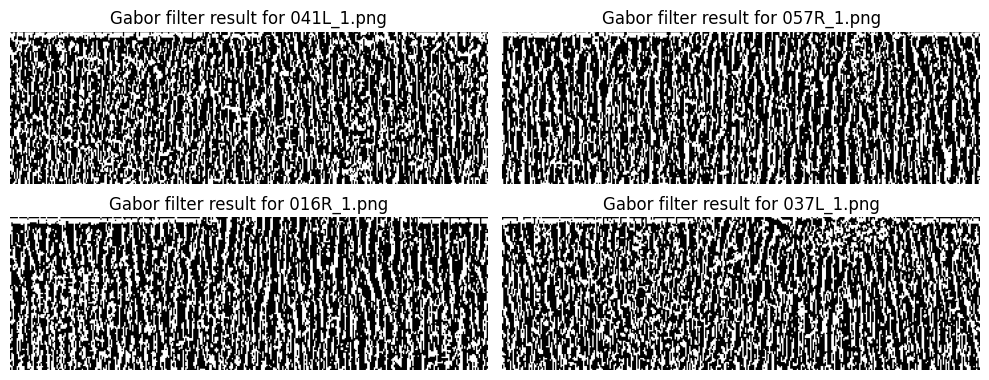

In [ ]:
# Выбираем 4 случайных результата из списка

fig, axs = plt.subplots(2, 2, figsize=(10, 4)) # создаем 2 строки по 2 столбца

for i in range(2):
    for j in range(2):
        random_image = random.choice(processed_images_train)  # выбираем случайное изображение

        gabor_result = random_image['gabor_filter']

        axs[i, j].imshow(gabor_result, cmap='gray')
        axs[i, j].set_title('Gabor filter result for ' + random_image['file_name'])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# формируем список классов

CLASSES_TRAIN = [clss['label'] for clss in processed_images_train]
CLASSES_VALID = [clss['label'] for clss in processed_images_valid]
CLASSES_TEST = [clss['label'] for clss in processed_images_test]

print(f'Пример названий классов тренировочной выборки: {CLASSES_TRAIN[0:10]}')
print(f'Пример названий классов валидационной выборки: {CLASSES_VALID[0:10]}')
print(f'Пример названий классов тестовой выборки: {CLASSES_TEST[0:10]}')

Пример названий классов тренировочной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов валидационной выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Пример названий классов тестовой выборки: ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']


In [ ]:
# создаем список классов для подмены

CLASSES_TRAIN_NEW = np.array(range(0, len(CLASSES_TRAIN)))
CLASSES_VALID_NEW = np.array(range(0, len(CLASSES_VALID)))
CLASSES_TEST_NEW = np.array(range(0, len(CLASSES_TEST)))

labels_train = [img['label'] for img in processed_images_train]
labels_valid = [img['label'] for img in processed_images_valid]
labels_test = [img['label'] for img in processed_images_test]

# заменяем значения меток на новые классы

labels_train_changed = np.where(np.isin(labels_train, CLASSES_TRAIN), CLASSES_TRAIN_NEW[np.searchsorted(CLASSES_TRAIN, labels_train)], labels_train)
labels_valid_changed = np.where(np.isin(labels_valid, CLASSES_VALID), CLASSES_VALID_NEW[np.searchsorted(CLASSES_VALID, labels_valid)], labels_valid)
labels_test_changed = np.where(np.isin(labels_test, CLASSES_TEST), CLASSES_TEST_NEW[np.searchsorted(CLASSES_TEST, labels_test)], labels_test)

# выводим результаты
print('Тренировочная выборка:')
print("Список классов: ", CLASSES_TRAIN[0:10])
print("Массив меток: ", labels_train[0:10])
print("Измененный массив меток: ", labels_train_changed[0:10])
print("Количество классов: ", len(CLASSES_TRAIN_NEW))

print('\nВалидационная выборка:')
print("Список классов: ", CLASSES_VALID[0:10])
print("Массив меток: ", labels_valid[0:10])
print("Измененный массив меток: ", labels_valid_changed[0:10])
print("Количество классов: ", len(CLASSES_VALID_NEW))

print('\nТестовая выборка:')
print("Список классов: ", CLASSES_TEST[0:10])
print("Массив меток: ", labels_test[0:10])
print("Измененный массив меток: ", labels_test_changed[0:10])
print("Количество классов: ", len(CLASSES_TEST_NEW))

Тренировочная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Количество классов:  128

Валидационная выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Количество классов:  128

Тестовая выборка:
Список классов:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Массив меток:  ['001L', '001R', '002L', '002R', '003L', '003R', '004L', '004R', '005L', '005R']
Измененный массив меток:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Количество классов:  128


### Подготовка датасета к обучению

In [ ]:
# формируем выборки

x_train_data = np.array([img['gabor_filter'] for img in processed_images_train]).reshape(-1, 115, 360, 1)
y_train_data = np.array(labels_train_changed)

x_valid_data = np.array([img['gabor_filter'] for img in processed_images_valid]).reshape(-1, 115, 360, 1)
y_valid_data = np.array(labels_valid_changed)

x_test_data = np.array([img['gabor_filter'] for img in processed_images_test]).reshape(-1, 115, 360, 1)
y_test_data = np.array(labels_test_changed)


print('Размер тренировочной выборки:', x_train_data.shape, y_train_data.shape)
print('Размер валидационной выборки:', x_valid_data.shape, y_valid_data.shape)
print('Размер тестовой выборки:', x_test_data.shape, y_test_data.shape)

Размер тренировочной выборки: (128, 115, 360, 1) (128,)
Размер валидационной выборки: (128, 115, 360, 1) (128,)
Размер тестовой выборки: (128, 115, 360, 1) (128,)


In [ ]:
# Нормированние массива изображений

#x_train = x_train_data / 255.
#x_valid = x_valid_data / 255.

In [ ]:
# проводим ohe преобразование для целевой переменной

y_train = to_categorical(y_train_data, 128)
y_valid = to_categorical(y_valid_data, 128)
y_test = to_categorical(y_test_data, 128)


print('Количество классов:', len(y_train[0]))
print('Пример ohe: \n', y_train[0])

Количество классов: 128
Пример ohe: 
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Создание генератора изображений с аугментацией

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Нормализация значений пикселей
    rotation_range=5,  # Случайные повороты изображения
    width_shift_range=0.1,  # Случайное смещение по горизонтали
    height_shift_range=0.1,  # Случайное смещение по вертикали
    shear_range=0.1,  # Случайные сдвиги
    zoom_range=0.1,  # Случайное увеличение масштаба
    horizontal_flip=True,  # Отражение изображения по горизонтали
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

# Создаем генераторы для тренировочных и валидационных данных
train_generator = train_datagen.flow(x_train_data, y_train, batch_size=batch_size, shuffle=False)

validation_generator = validation_datagen.flow(x_valid_data, y_valid, batch_size=batch_size, shuffle=False)

In [ ]:
# фиксируем форму входных данных для нейросети

input_shape = x_train_data.shape[1:]
input_shape

(115, 360, 1)

### Формируем архитектуру модели

In [ ]:
# собираем архитектуру нейросети

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=input_shape, activation='relu', padding='same'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(1024, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(512, (2,2), activation='relu', padding='same'))
model.add(SpatialDropout2D(0.2))

model.add(Conv2D(512, (2,2), activation='relu', padding='same'))

model.add(Conv2D(512, (2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(y_train[0]), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 115, 360, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 360, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 57, 180, 128)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 57, 180, 128)     0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 180, 1024)     1180672   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 90, 1024)     0

In [ ]:
# компилируем модель

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

In [ ]:
# фиксируем гиперпараметры для обучения

params = {'batch_size' : 32,
          'epochs' : 40,
         }

In [ ]:
# обучаем модель

history = model.fit(train_generator, **params, validation_data=validation_generator, verbose=1)

Epoch 1/40
4/4 [==============================] - 32s 2s/step - loss: 4.8490 - accuracy: 0.0000e+00 - val_loss: 4.8521 - val_accuracy: 0.0078
Epoch 2/40
4/4 [==============================] - 6s 2s/step - loss: 4.8506 - accuracy: 0.0078 - val_loss: 4.8521 - val_accuracy: 0.0078
Epoch 3/40
4/4 [==============================] - 6s 2s/step - loss: 4.8545 - accuracy: 0.0078 - val_loss: 4.8522 - val_accuracy: 0.0078
Epoch 4/40
4/4 [==============================] - 6s 2s/step - loss: 4.8643 - accuracy: 0.0000e+00 - val_loss: 4.8523 - val_accuracy: 0.0078
Epoch 5/40
4/4 [==============================] - 6s 2s/step - loss: 4.8641 - accuracy: 0.0078 - val_loss: 4.8522 - val_accuracy: 0.0078
Epoch 6/40
4/4 [==============================] - 6s 2s/step - loss: 4.8590 - accuracy: 0.0078 - val_loss: 4.8522 - val_accuracy: 0.0078
Epoch 7/40
4/4 [==============================] - 6s 2s/step - loss: 4.8470 - accuracy: 0.0000e+00 - val_loss: 4.8523 - val_accuracy: 0.0078
Epoch 8/40
4/4 [============

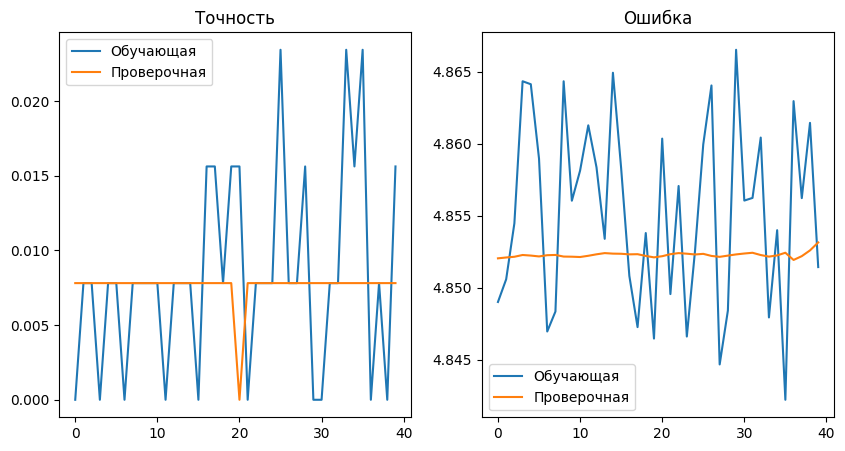

In [ ]:
# строим график обучения модели

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Обучающая')
plt.plot(history.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Обучающая')
plt.plot(history.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()

### Выводы